# **CREDIT RISK MODELING**

---

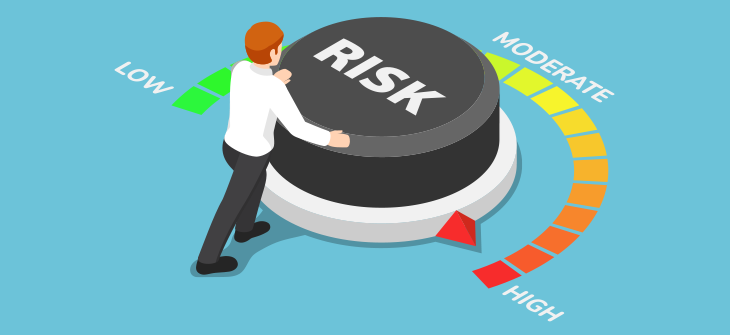






## **Problem statement**
Customers apply for various kinds of loans in a bank. The branch
manager has the responsibility to determine if you should approve a loan application or not. The
manager hires you as a data scientist, and asks you to understand and predict if the customer
will be able to repay the loans or not. This dataset will help to determine such abilities of each
customer. It contains a feature named “Target” where 1 represents customers with payment
difficulties (like he/she had late payment more than X days on at least one of the first Y
installments of the loan or any previous loan), and 0 for all other cases.

## **Architecture diagram**
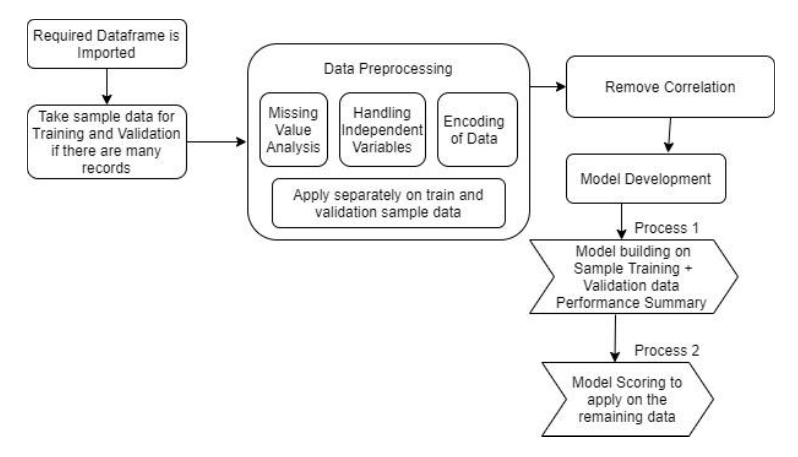

### **Import required Libraries**

In [ ]:
#@title Imporing Libraries: numpy, pandan, matplotlib, seaborn, plotly, sklearn, PandasProfiling, SMOTETOmek.
import numpy as np
import pandas as pd
import csv
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
#@title Mounting Google Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#@title 
cd '/gdrive/My Drive/Credit Risk Modeling/'

/gdrive/My Drive/Credit Risk Modeling


In [ ]:
#@title Reading Dataset
df=pd.read_csv("credit_risk_file.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (3,4,5,6,12,13,14,15,16,29,33,41,87,88,90,91) have mixed types.Specify dtype option on import or set low_memory=False.



In [ ]:
#@title Getting a gist of the dataset
df

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,PREVIOUS_LOAN_COUNTS_BUREAU,AMT_CREDIT_SUM_OVERDUE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,PREVIOUS_LOAN_COUNTS_CC,AMT_RECIVABLE,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_TOTAL_RECEIVABLE,SK_DPD,AMT_DRAWINGS,CNT_DRAWINGS,NUM_INSTALMENT_NUMBER,AMT_INSTALMENT,PREVIOUS_COUNTS_INST,AMT_PAYMENT,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,PREVIOUS_CASH_LOAN_COUNTS,AMT_APPLICATION,CNT_PAYMENT,PREVIOUS_COUNTS,AMT_DOWN_PAYMENT
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.500,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,0,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,865055.565,245781.0,8,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,190,219625.695,19,219625.695,456,285,19,0.0,0,0,0.0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.500,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,0,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1017400.500,0.0,4,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,127,1618864.650,25,1618864.650,283,162,28,0.0,0,0,0.0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.000,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,189037.800,0.0,2,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,6,21288.465,3,21288.465,15,9,4,0.0,0,0,0.0
3,3,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.500,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,0,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,146250.000,0.0,1,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,465,835985.340,66,806127.975,1012,592,66,0.0,0,0,0.0
4,4,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.500,454500.0,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,0,1,1,1,1,1,0,Laborers,2,2,2,WEDNESDAY,16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,468445.500,240057.0,3,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,177,969603.750,35,957617.595,956,341,83,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692167,692167,456251,0,0,0,0,0,0,0.0,40455.0,6605.910,0.0,0,0,0,0,0,0.000000,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0,0,0.000,0,0.000,0,0,0,40455.0,8,1,0.0
692168,692168,456252,0,0,0,0,0,0,0.0,56821.5,10074.465,0.0,0,0,0,

### **Data Preprocessing**

In [ ]:
#@title Removing Rows with zero values
df = df[df['NAME_CONTRACT_TYPE'] != 0]
df = df[df['NAME_CONTRACT_TYPE'] != '0']
df.shape

(263491, 148)

In [ ]:
#@title Calculation of total_payments & total_dues
df['total_payment'] = df['AMT_DOWN_PAYMENT'] + df['AMT_PAYMENT_TOTAL_CURRENT']
df['amount_dues'] = df['AMT_CREDIT'] + (df['AMT_CREDIT_LIMIT_ACTUAL'] - df['AMT_BALANCE'] - df['AMT_PAYMENT_TOTAL_CURRENT'])
df.shape

(263491, 150)

In [ ]:
#@title Data Validation
df = df[df['total_payment'] < df['amount_dues']]
df = df[df['amount_dues'] >= 0]
df.shape

(261082, 150)

**Loss given default (LGD)** is the amount of money a bank or other financial institution loses when a borrower defaults on a loan, depicted as a percentage of total exposure at the time of default. A financial institution’s total LGD is calculated after a review of all outstanding loans using cumulative losses and exposure.<br>
It means how much of the amount outstanding we expect to lose. It is a proportion of the total exposure when borrower defaults. It is calculated by (1 - Recovery Rate).

In [ ]:
#@title Calculation of columns **remaining** and **LGD**
df['remaining'] = df['amount_dues'] - df['total_payment']
df['recovery_rate'] = df['total_payment'] / (df['amount_dues'] + df['total_payment'])
df['LGD'] = 1 - df['recovery_rate']
df.shape

(261082, 153)

In [ ]:
#@title Data Validation on LGD
print(df[df['LGD'] > 1].shape)
print(df[df['LGD'] < 0].shape)

(0, 153)
(0, 153)


### **Categorical dataframe separation**

In [ ]:
cat_df=df.select_dtypes(include=['object'])
cat_df.columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [ ]:
cat_df.nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               19
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             5
HOUSETYPE_MODE                 4
WALLSMATERIAL_MODE             8
EMERGENCYSTATE_MODE            3
dtype: int64

In [ ]:
cat_df1 = cat_df.drop(['OCCUPATION_TYPE','ORGANIZATION_TYPE'], axis=1)
cat_df1.shape

(261082, 14)

In [ ]:
cat_df1 = pd.get_dummies(cat_df1)
cat_df1.shape

(261082, 69)

### **Numerical data seperation**

In [ ]:
num_df=df.select_dtypes(include=['int','float'])
num_df.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       ...
       'PREVIOUS_CASH_LOAN_COUNTS', 'AMT_APPLICATION', 'CNT_PAYMENT',
       'PREVIOUS_COUNTS', 'AMT_DOWN_PAYMENT', 'total_payment', 'amount_dues',
       'remaining', 'recovery_rate', 'LGD'],
      dtype='object', length=137)

In [ ]:
num_df.nunique()

Unnamed: 0          261082
SK_ID_CURR          261082
TARGET                   2
CNT_CHILDREN            15
AMT_INCOME_TOTAL      2164
                     ...  
total_payment        44536
amount_dues          69201
remaining            69213
recovery_rate        50309
LGD                  50309
Length: 137, dtype: int64

### **EDA**

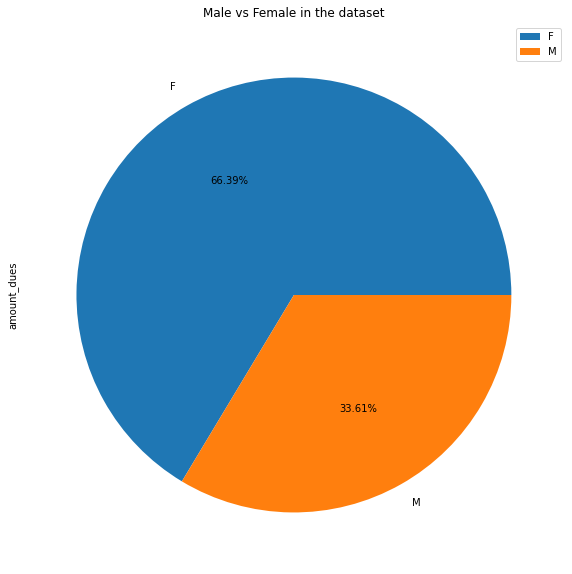

In [ ]:
#@title Pie- Chart to compare total_dues of males and females
tempM = df[df['CODE_GENDER'] == 'M']
tempF = df[df['CODE_GENDER'] == 'F']
temp = pd.concat([tempM, tempF], axis=0)
temp.groupby(['CODE_GENDER']).count().plot.pie(y='amount_dues', figsize=(10,10), autopct='%1.2f%%', title="Male vs Female in the dataset")

From the Pie- Plot we can observe that there Female Clients who have applied for the loans show **more dues** than Men.

In [ ]:
print(df['AMT_INCOME_TOTAL'].min())
print(df['AMT_INCOME_TOTAL'].max())
bins = [0, 25000, 50000, 75000, 100000,1000000]
slot = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 and above']
df['AMT_INCOME_BIN'] = pd.cut(df['AMT_INCOME_TOTAL'], bins, labels=slot)
tempY=df['AMT_INCOME_TOTAL'][df['FLAG_OWN_CAR']=='Y']
tempN=df['AMT_INCOME_TOTAL'][df['FLAG_OWN_CAR']=='N']
conn=pd.concat([tempY,tempN],axis=1)
temp_tot=df['AMT_INCOME_TOTAL']
bins = [0, 25000, 50000, 75000, 100000,1000000]
tempY=pd.cut(tempY,bins).value_counts()
temp_tot=pd.cut(temp_tot,bins).value_counts()
per= tempY.div(temp_tot)*100

26100.0
117000000.0


Text(0.5, 1.0, 'Percentage of People owning cars In each Income Groups')

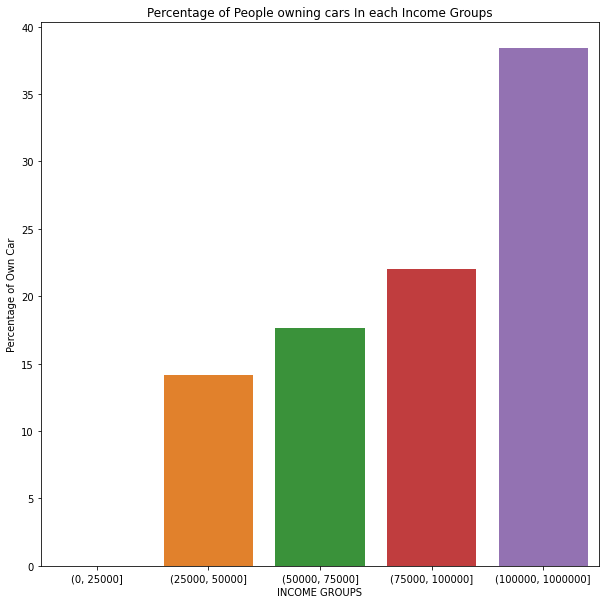

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(x=per.index,y=per)
plt.ylabel('Percentage of Own Car')
plt.xlabel('INCOME GROUPS')
plt.title('Percentage of People owning cars In each Income Groups')

People having more number of cars falls under higher category range

Text(0.5, 1.0, 'Percentage of Defaulters for each category of Education Type')

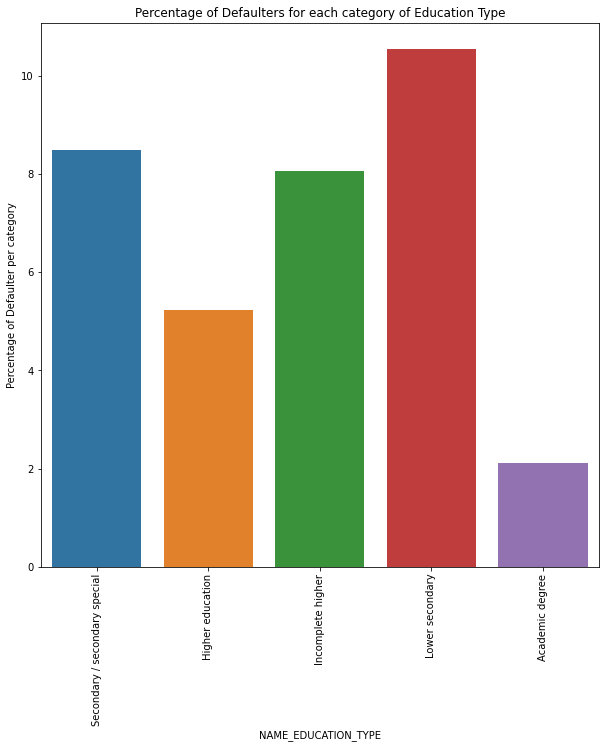

In [ ]:
plt.figure(figsize=(10,10))
percentage_defaulter_per_category = (df['NAME_EDUCATION_TYPE'][df.TARGET == 1].value_counts() * 100 / df['NAME_EDUCATION_TYPE'].value_counts()).dropna()
sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category)
plt.ylabel('Percentage of Defaulter per category')
plt.xlabel('NAME_EDUCATION_TYPE')
plt.xticks(rotation=90)
plt.title('Percentage of Defaulters for each category of Education Type')



*   People having the education of Lower Secondary tend to show more defaulting characteristic
*   Whereas the people having an Academic Degree have the least defaulting characteristic



Text(0.5, 1.0, 'Percentage of Defaulters with CNT_CHILDREN')

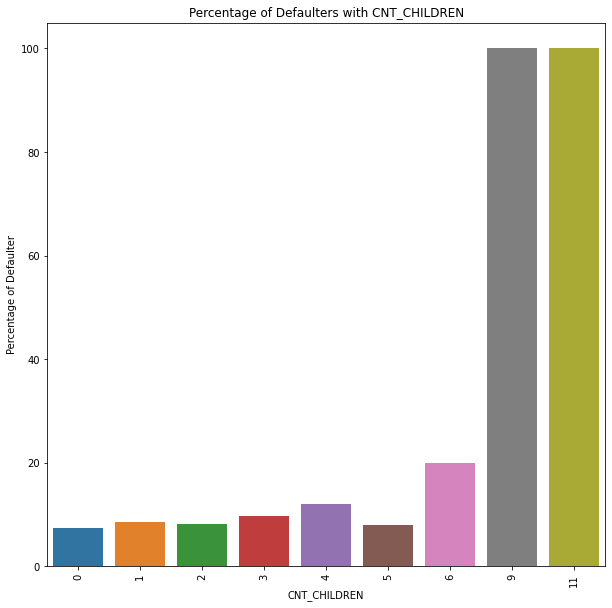

In [ ]:
plt.figure(figsize=(10,10))
percentage_defaulter_per_category = (df['CNT_CHILDREN'][df.TARGET == 1].value_counts() * 100 / df['CNT_CHILDREN'].value_counts()).dropna()
sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category)
plt.ylabel('Percentage of Defaulter')
plt.xlabel('CNT_CHILDREN')
plt.xticks(rotation=90)
plt.title('Percentage of Defaulters with CNT_CHILDREN')

Customers having more no. of children shows greater defaulting characteristic

Text(0.5, 1.0, 'Percentage of Defaulters In each age groups')

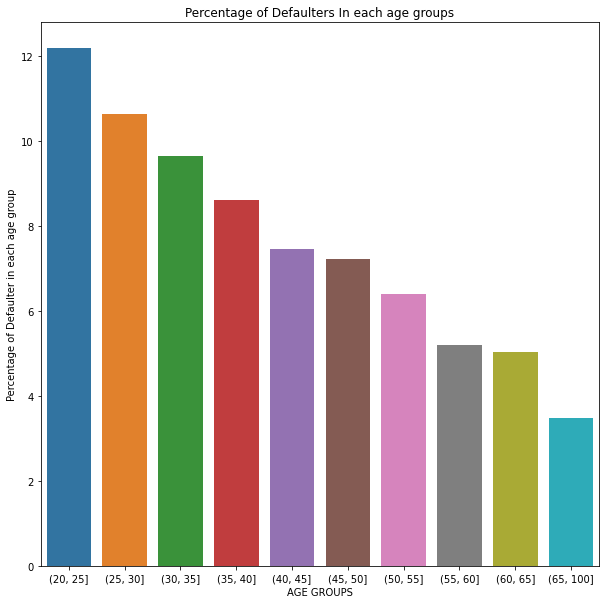

In [ ]:
temp0=df['DAYS_BIRTH'][df['TARGET']==0]
temp1=df['DAYS_BIRTH'][df['TARGET']==1]
con=pd.concat([temp0,temp1],axis=1)
temp_total=df['DAYS_BIRTH']/-365
bins=[20,25,30,35,40,45,50,55,60,65,100]
temp1=pd.cut(temp1/-365,bins).value_counts()
temp_total=pd.cut(temp_total,bins).value_counts()
percent = temp1.div(temp_total)*100
plt.figure(figsize=(10,10))
sns.barplot(x=percent.index,y=percent)
plt.ylabel('Percentage of Defaulter in each age group')
plt.xlabel('AGE GROUPS')
plt.title('Percentage of Defaulters In each age groups')

Customers falling in the age group 20-25 tend to shows higher defaulting characteristic.
We can also observe that people in older age groups shows less defaulting characteristic

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text major ticklabel objects>)

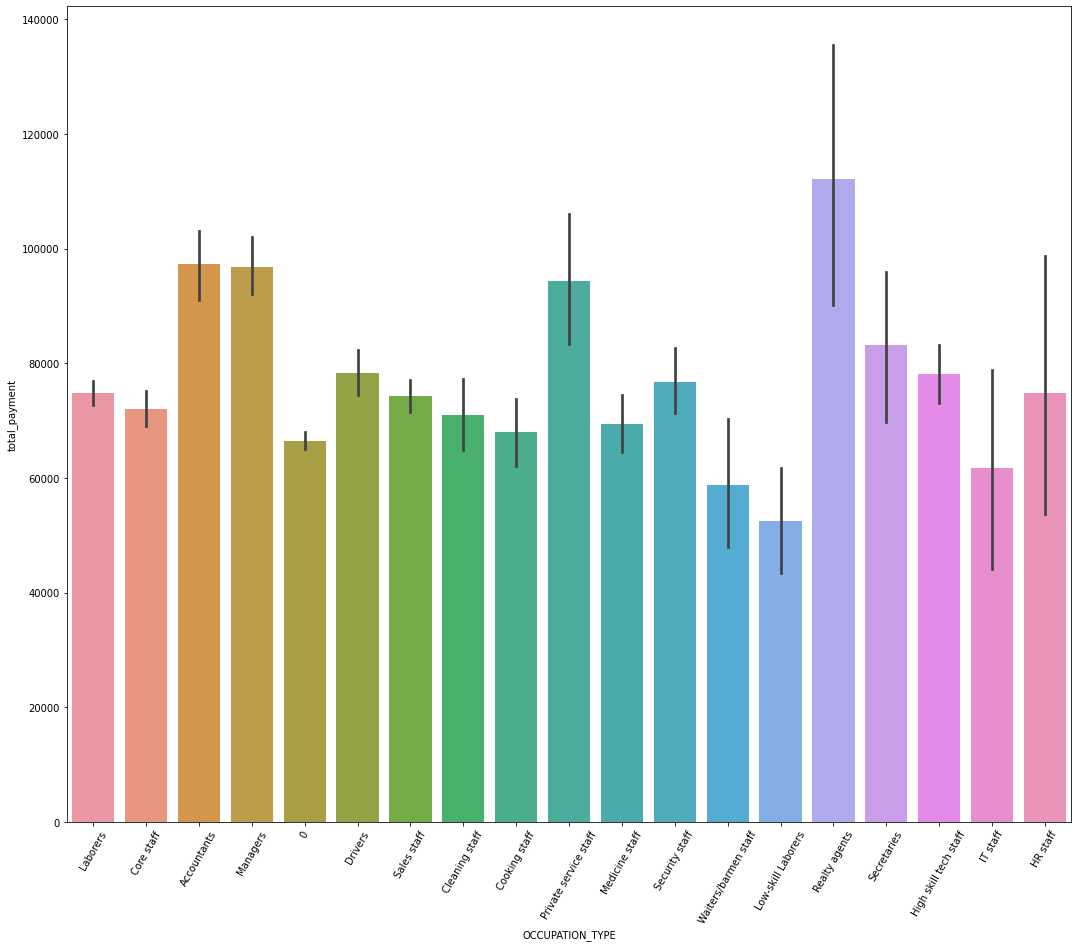

In [ ]:
fig, ax=plt.subplots(figsize=(18,15))
sns.barplot(x=df['OCCUPATION_TYPE'],y=df['total_payment'], ax=ax)
plt.xticks(rotation=60)



*   The occupation type low-skill labourers show least total payments
*   The occupation type Reality agent shows highest total payments



### **Pandas Profiling**

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
from pandas_profiling import ProfileReport
def report(dataset, title, filename):
  profile = ProfileReport(dataset, title=title, minimal=True)
  return profile.to_file(filename)
report(df,"Report","output.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Insights from Pandas Profiling**
1. FLAG_MOBIL has constant value "1.0"	
2. FLAG_DOCUMENT_2 has constant value "0.0"	
3. AMT_DOWN_PAYMENT has constant value "0.0"
4. df_index has unique values
5. Unnamed: 0 has unique values	
6. SK_ID_CURR has unique values 


## **Creation of new dataframe**

In [ ]:
#@title Concatinating categorical and numerical dataframe
new_df = pd.concat([cat_df1, num_df], axis=1)
new_df.shape

(261082, 206)

## **Feature Engineering**

In [ ]:
#@title Droping columns causing multicolinearity 
new_df = new_df.drop(['AMT_DOWN_PAYMENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_CREDIT', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_BALANCE', 'total_payment', 'amount_dues', 'recovery_rate'], axis=1)
new_df.shape

(261082, 198)

In [ ]:
#@title Droping features having constant or unique values
new_df = new_df.drop(['FLAG_MOBIL', 'Unnamed: 0', 'SK_ID_CURR', 'DAYS_ID_PUBLISH'], axis=1)
new_df.shape

(261082, 194)

In [ ]:
#@title Aggregating the 20 Documents to DOCUMENT_SUM
cl1 = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

new_df['DOCUMENT_SUM'] = new_df[cl1].sum(axis=1)
print("Minimum documents provided=",new_df['DOCUMENT_SUM'].min())
print("Minimum documents provided=",new_df['DOCUMENT_SUM'].max())
# from max 20 docs, we see max of 4 docs (20%) => docs delete
print(new_df.shape)
new_df = new_df.drop(cl1, axis=1)
new_df.shape

Minimum documents provided= 0
Minimum documents provided= 4
(261082, 195)


(261082, 175)

In [ ]:
#@title Segregation of customers into 2 types:
#@markdown 1. Documents Provided
#@markdown 2. Documents not Provided 
new_df['FLAG_DOCUMENT_SUM'] = np.NaN
for index, row in new_df.iterrows():
  if row['DOCUMENT_SUM'] == 0:
    new_df.at[index, 'FLAG_DOCUMENT_SUM'] = 0
  else: new_df.at[index, 'FLAG_DOCUMENT_SUM'] = 1
new_df = new_df.drop(['DOCUMENT_SUM'], axis=1)

In [ ]:
#@title Number of inquries to credit bureau in the past 1 year
cl2 = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
new_df['AMT_REQ_CREDIT_BUREAU_TOTAL'] = new_df[cl2].sum(axis=1)
print("Minimum no of inquries=",new_df['AMT_REQ_CREDIT_BUREAU_TOTAL'].min())
print("Maximum no of inquries=",new_df['AMT_REQ_CREDIT_BUREAU_TOTAL'].max())
print(new_df.shape)
new_df = new_df.drop(cl2, axis=1)
new_df.shape

Minimum no of inquries= 0
Maximum no of inquries= 262
(261082, 176)


(261082, 170)

In [ ]:
#@title 
cl3 = ['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE']
print(new_df.shape)
new_df = new_df.drop(cl3, axis=1)
new_df.shape

(261082, 170)


(261082, 127)

## **Feature Selection**

In [ ]:
#@title Dependent & Independent variables
x = (new_df.loc[:, new_df.columns != 'TARGET']) 
y = (new_df['TARGET'] )

In [ ]:
#@title ExtraTreesClassifier for Feature Selection
model=ExtraTreesClassifier()
model.fit(x,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

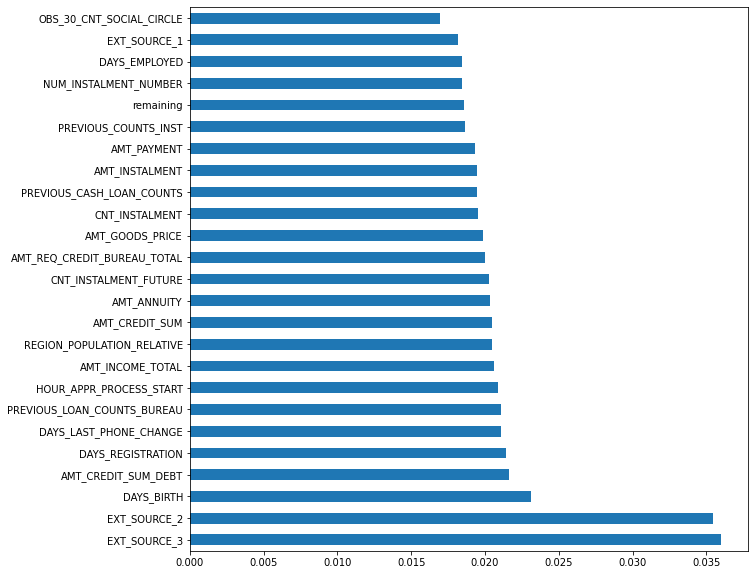

In [ ]:
#@title Ploting top 25 features
feature_importance=pd.Series(model.feature_importances_,index=x.columns)
plt.figure(figsize=(10,10))
feature_importance.nlargest(25).plot(kind='barh')
plt.show()

In [ ]:
#@title 
col=['EXT_SOURCE_2',                  
'EXT_SOURCE_3',               
'DAYS_BIRTH',                    
'AMT_CREDIT_SUM_DEBT',            
'DAYS_REGISTRATION',              
'DAYS_LAST_PHONE_CHANGE',         
'PREVIOUS_LOAN_COUNTS_BUREAU',    
'HOUR_APPR_PROCESS_START',      
'AMT_CREDIT_SUM',              
'AMT_INCOME_TOTAL',               
'CNT_INSTALMENT_FUTURE',          
'REGION_POPULATION_RELATIVE',   
'AMT_ANNUITY',                    
'AMT_REQ_CREDIT_BUREAU_TOTAL',    
'AMT_GOODS_PRICE',              
'CNT_INSTALMENT',               
'AMT_INSTALMENT',               
'PREVIOUS_CASH_LOAN_COUNTS',      
'AMT_PAYMENT',                   
'NUM_INSTALMENT_NUMBER',       
'DAYS_EMPLOYED',                  
'PREVIOUS_COUNTS_INST',           
'remaining',                     
'EXT_SOURCE_1',                   
'OBS_30_CNT_SOCIAL_CIRCLE'        
]
len(col)

25

In [ ]:
#@title Creation of final dataframe
final_df = pd.DataFrame()
for i in col:
  final_df = pd.concat([final_df, new_df[i]], axis=1)
final_df.shape

(261082, 25)

In [ ]:
#@title Segregating final dataframe into dependent and independent variables
x = (final_df.loc[:, final_df.columns != 'TARGET']) 
y= (new_df['TARGET'] )


### **Over & under Sampling using SMOTETomek**

In [ ]:
from imblearn.combine import SMOTETomek
from collections import Counter
smk = SMOTETomek()

In [ ]:
x_train_smote,y_train_smote=smk.fit_sample(x,y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
print('Original shape {}'.format(Counter(y)))
print('Resampled shape {}'.format(Counter(y_train_smote)))

Original shape Counter({0: 241032, 1: 20050})
Resampled shape Counter({1: 239072, 0: 239072})


### **Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_smote, y_train_smote, test_size=0.2, random_state=100, stratify=y_train_smote)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(382515, 25) (95629, 25) (382515,) (95629,)


In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x_train, y_train, test_size=0.2, random_state=100, stratify=y_train)
print(x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)

(306012, 25) (76503, 25) (306012,) (76503,)


### **Standardization**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train1)
scaler_train = scaler.transform(x_train1)
scaler_cv = scaler.transform(x_test1)
scaler_test = scaler.transform(x_test)

### **Model: Logistic Regression**

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier

In [ ]:
reg=SGDClassifier()
reg.fit(scaler_train,y_train1)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_train_pred = reg.predict(scaler_train)    
y_test_pred = reg.predict(scaler_test)

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [ ]:
print('LogisticRegression Accuracy: %.3f' % auc(test_fpr, test_tpr))

LogisticRegression Accuracy: 0.678


In [ ]:
print("Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred),"\n")
print("Precision : ",precision_score(y_test, y_test_pred)) 
print("Recall : ",recall_score(y_test, y_test_pred)) 
print("F1- Score : ",f1_score(y_test, y_test_pred),"\n")

Confusion Matrix : 
 [[31695 16120]
 [14689 33125]] 

Precision :  0.6726571225505127
Recall :  0.6927887229681683
F1- Score :  0.682574516531182 



### **Model: XGBoost**

In [ ]:
from sklearn.model_selection import StratifiedKFold 

k=StratifiedKFold(n_splits=3, shuffle=True)
print(k)

StratifiedKFold(n_splits=3, random_state=None, shuffle=True)


In [ ]:
from xgboost.sklearn import XGBClassifier 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import RandomizedSearchCV


In [ ]:
model=XGBClassifier()
model.fit(scaler_train,y_train1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_train_pred = model.predict(scaler_train)    
y_test_pred = model.predict(scaler_test)

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [ ]:
print("Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred),"\n")
print("Precision : ",precision_score(y_test, y_test_pred)) 
print("Recall : ",recall_score(y_test, y_test_pred)) 
print("F1- Score : ",f1_score(y_test, y_test_pred),"\n") 

Confusion Matrix : 
 [[46508  1307]
 [ 5516 42298]] 

Precision :  0.9700263731223484
Recall :  0.8846362989919271
F1- Score :  0.9253656242137849 



In [ ]:
print('XGBoost Accuracy: %.3f' % auc(test_fpr, test_tpr))

XGBoost Accuracy: 0.929


### **Model: Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier  

In [ ]:
clf=DecisionTreeClassifier()

In [ ]:
clf.fit(scaler_train,y_train1)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_train_pred = clf.predict(scaler_train)    
y_test_pred = clf.predict(scaler_test)

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [ ]:
print("Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred),"\n")
print("Precision : ",precision_score(y_test, y_test_pred)) 
print("Recall : ",recall_score(y_test, y_test_pred)) 
print("F1-Score : ",f1_score(y_test, y_test_pred),"\n") 

Confusion Matrix : 
 [[41850  5965]
 [ 5034 42780]] 

Precision :  0.8776284747153554
Recall :  0.8947170284853808
F1-Score :  0.8860903696185752 



In [ ]:
print('Decision Tree Accuracy: %.3f' % auc(test_fpr, test_tpr))

Decision Tree Accuracy: 0.885


### **Model- Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
random=RandomForestClassifier()

In [ ]:
random.fit(scaler_train,y_train1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_train_pred = random.predict(scaler_train)    
y_test_pred = random.predict(scaler_test)

In [ ]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train1, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

In [ ]:
print("Confusion Matrix : \n", confusion_matrix(y_test, y_test_pred),"\n")
print("Precision : ",precision_score(y_test, y_test_pred)) 
print("Recall : ",recall_score(y_test, y_test_pred)) 
print("F1- Score : ",f1_score(y_test, y_test_pred),"\n")

Confusion Matrix : 
 [[46484  1331]
 [ 4140 43674]] 

Precision :  0.9704255082768581
Recall :  0.913414481114318
F1- Score :  0.9410573266249367 



In [ ]:
print('RandomForest Accuracy: %.3f' % auc(test_fpr, test_tpr))

RandomForest Accuracy: 0.943


## Model Selection

In [ ]:
#@title Comparison of models
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Precision",'Recall', "F1 score", "Accuracy"]
x.add_row(['Logistic Regression', 0.67, 0.71, 0.70, 0.68])
x.add_row(['XGBoost', 0.97, 0.89, 0.93, 0.93])
x.add_row(['Random Forest', 0.97, 0.91, 0.94, 0.94])
x.add_row(['Decision Tree', 0.87, 0.89, 0.88, 0.88])
print(x)

+---------------------+-----------+--------+----------+----------+
|        Model        | Precision | Recall | F1 score | Accuracy |
+---------------------+-----------+--------+----------+----------+
| Logistic Regression |    0.67   |  0.71  |   0.7    |   0.68   |
|       XGBoost       |    0.97   |  0.89  |   0.93   |   0.93   |
|    Random Forest    |    0.97   |  0.91  |   0.94   |   0.94   |
|    Decision Tree    |    0.87   |  0.89  |   0.88   |   0.88   |
+---------------------+-----------+--------+----------+----------+


From above comparison, we choose **Random Forest** as our final model